In [2]:
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
import numpy as np

In [3]:
%autosave 10

Autosaving every 10 seconds


# Opis eksperymentu i sprzętu

Eksperymentu zostały wykonane na Lenovo y50-70 z procesorem Intel® Core™ i7-4710HQ CPU @ 2.50GHz × 8, 16 GB RAM, kartą graficzną Nvidia GeForce GTX 860M (Cuda Capability Major 5.0, 4044 MB global memory, 640 Cuda Cores, 49152 bajtów shared memory na blok, rozmiar <b> warp 32 </b>)

Wykorzystałem kody udostepnione na zajęciach z drobną zmianą pozwalającą wprowadzać rozmiar siatki i bloku. Zaimplementowałem jednowątkowy program w języku C++, aby porównać wydajność CPU i GPU.

Zmieniałem rozmiar siatki zaczynając od 32 do 3520 z krokiem 32, rozmiar bloku od 8 do 32 z krokiem 8 dla wszystkich trzech typów pamięci. Program na CPU wykonywałem dla rozmiaru siatki od 32 do 1600 z krokiem 32.

Wykorzystałem profiler nvprof, aby wyznaczyć metrykę achieve occupancy. Zmieniałem tam rozmiary danych wejściowych jak wyżej, natomiast na wykresie przedstawiłem rezultaty tylko dla N mniejszego od 1600.


# Krótki opis funkcjonalności i sposobu użytkowania pamięci tekstur

###  Co to jest pamięć tekstury w CUDA?

Pamięć tekstury to cache'owalna pamięć typu read-only. Cache tekstur jest zoptymalizowany pod kątem dostępności lokalnej 2D, więc wątki w tym samym warpie, które czytają adresy tekstur blisko siebie osiągają najlepszą wydajność. Warto korzystać z pamięci tekstur jeżeli dane są rzadko aktualizowane i czytane często, nie warto kiedy dane są czytane raz po aktualizacji.

### Jak korzystać z pamięci tekstur w CUDA?
<ol>
    <li> Deklaracja pamięci tekstury w CUDA </li>
    <li> Binding pamięci tekstury do referencji tekstury </li>
    <li> Czytanie pamięci tekstury poprzez referencję tekstury </li>
    <li> Unbinding pamięci tekstury od referencji tekstury </li>
</ol>
Declare the texture memory in CUDA.
·         Bind the texture memory to your texture reference in CUDA.
·         Read the texture memory from your texture reference in CUDA Kernel.
·         Unbind the the texture memory from your texture reference in CUDA.

Źródło: http://cuda-programming.blogspot.com/2013/02/texture-memory-in-cuda-what-is-texture.html

# Krótki opis zachowania schedulara multiprocesora dla warpa jeśli w kodzie kernela znajduje się instrukcja warunkowa 

Różne warpy mogą wykonywać całkowicie różny kod. Nie ma wpływu na wydajność rózna kontrola przepływu programu. Każdy warp utrzymuje swój własny licznik(ang. program counter). Jeżeli jakaś część warpu musi wykonywać oprację, wątki które jej nie wykonują są wyłączone. Jeżeli conajmniej jeden wątek wewnątrz warpu musi wykonać pewną ścieżkę w  instrukcji kierunkowa, to cały warp będzie zajmował się tą ścieżką w instrkcji warunkowej.

Źródło (slajd 10):
#http://on-demand.gputechconf.com/gtc/2013/presentations/S3466-Programming-Guidelines-GPU-Architecture.pdf

# Porównanie wydajności obliczen dla różnych typów pamięci i róznych rozmiarów siatki

In [6]:
#Porównanie wydajności obliczenia dla różnych typów pamięci
#Porównanie wydajności obliczeń dla różnych rozmiarów siatki 
global_results = pd.read_csv("global_results.txt")
shared_results = pd.read_csv("shared_results.txt")
texture_results = pd.read_csv("texture_results.txt")

In [53]:
def time_grid_size_with_fixed_block(block):
    global_with_block_16 = global_results[global_results['block']==block]
    shared_results_16 = shared_results[shared_results['block'] == block]
    texture_results_16 = texture_results[texture_results['block'] == block]
    print ("Statystyki czasu wykonania dla pamieci global i bloku" + str(block))
    print(global_with_block_16['time '].describe())
    print()
    print ("Statystyki czasu wykonania dla pamieci shared i bloku " + str(block))
    print (shared_results_16['time '].describe())
    print()
    print ("Statystyki czasu wykonania dla pamieci texture i bloku " + str(block))
    print (texture_results_16['time '].describe())
    print()
    plt.figure(figsize=(8, 8))
    a = plt.scatter(global_with_block_16['N'], global_with_block_16['time '], color='green')
    b = plt.scatter(shared_results_16['N'], shared_results_16['time '], color='red')
    c = plt.scatter(texture_results_16['N'], texture_results_16['time '], color='blue')

    plt.legend(['Global memory', 'Shared memory', 'Texture memory'])
    plt.xlabel('Rozmiar siatki')
    plt.ylabel('Czas wykonania (s)')
    plt.title("Czas wykonania w zależności od rozmiaru siatki(stałego rozmiaru bloku = " + str(block) + ") dla różnych rodzajów pamięci")
    plt.show()

Statystyki dla pamieci global i bloku8
count    50.000000
mean     15.019740
std      13.131421
min       0.421567
25%       2.910835
50%      11.515000
75%      24.571075
max      42.224900
Name: time , dtype: float64

Statystyki dla pamieci shared i bloku 8
count    50.000000
mean     19.457468
std      16.904364
min       0.469663
25%       4.040730
50%      14.728850
75%      32.434875
max      54.770400
Name: time , dtype: float64

Statystyki dla pamieci texture i bloku 8
count    50.000000
mean     12.426994
std      10.705119
min       0.420616
25%       2.614312
50%       9.449545
75%      20.189100
max      34.633700
Name: time , dtype: float64



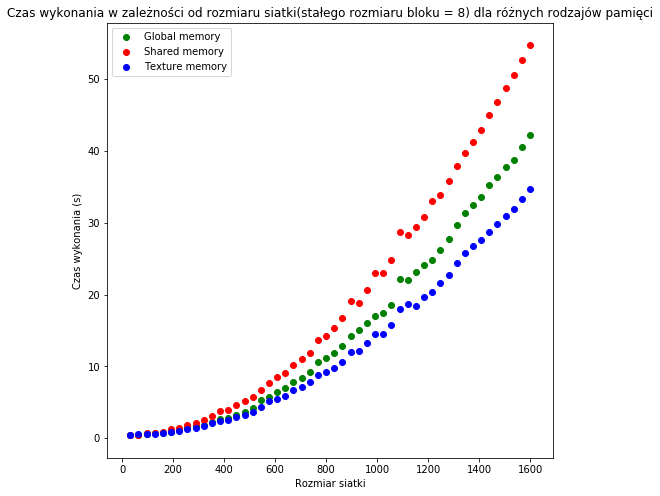

Statystyki dla pamieci global i bloku16
count    50.000000
mean     12.569170
std      10.897435
min       0.417488
25%       2.429735
50%       9.627600
75%      20.458650
max      35.522900
Name: time , dtype: float64

Statystyki dla pamieci shared i bloku 16
count    50.000000
mean     18.821484
std      16.430705
min       0.470214
25%       3.635495
50%      14.390100
75%      30.732575
max      53.506100
Name: time , dtype: float64

Statystyki dla pamieci texture i bloku 16
count    50.000000
mean     10.849263
std       9.372805
min       0.412188
25%       1.910068
50%       8.424470
75%      17.582500
max      30.285400
Name: time , dtype: float64



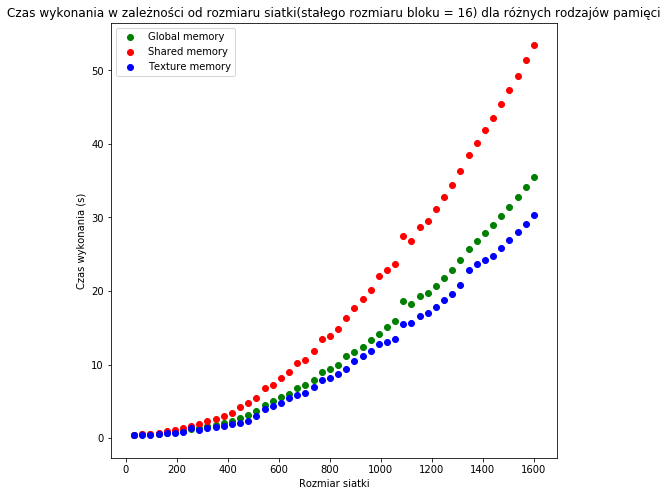

Statystyki dla pamieci global i bloku24
count    50.000000
mean     13.597120
std      11.757546
min       0.418620
25%       2.714618
50%      10.674700
75%      22.144200
max      38.137600
Name: time , dtype: float64

Statystyki dla pamieci shared i bloku 24
count    50.000000
mean     21.143945
std      18.474634
min       0.469982
25%       4.189493
50%      16.624350
75%      34.770425
max      59.979000
Name: time , dtype: float64

Statystyki dla pamieci texture i bloku 24
count    50.000000
mean     12.849698
std      11.144894
min       0.407597
25%       2.421158
50%      10.090855
75%      21.012950
max      36.115600
Name: time , dtype: float64



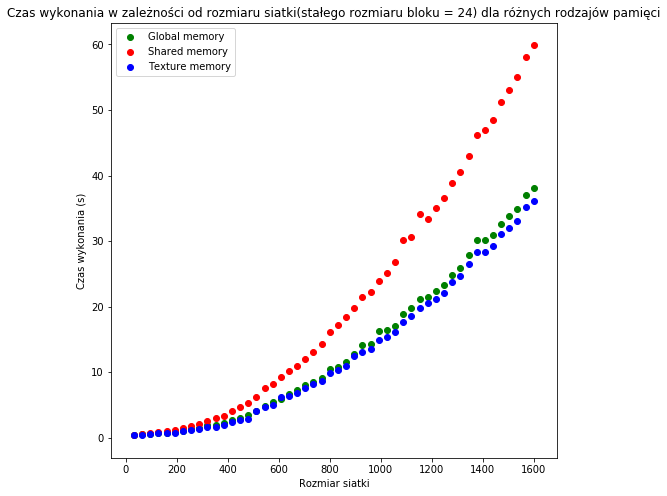

Statystyki dla pamieci global i bloku32
count    50.000000
mean     13.191837
std      11.512621
min       0.467121
25%       2.596225
50%      10.093000
75%      21.484525
max      38.174700
Name: time , dtype: float64

Statystyki dla pamieci shared i bloku 32
count     49.000000
mean      44.046937
std       38.705301
min        0.630300
25%        8.782430
50%       34.144100
75%       72.147300
max      126.292000
Name: time , dtype: float64

Statystyki dla pamieci texture i bloku 32
count    49.000000
mean     11.868047
std      10.271512
min       0.444891
25%       2.157460
50%       9.914190
75%      19.375200
max      33.309200
Name: time , dtype: float64



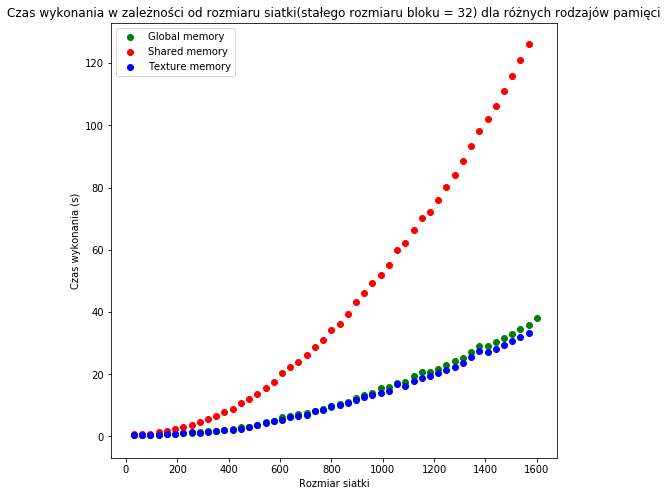

In [52]:
time_grid_size_with_fixed_block(8)
time_grid_size_with_fixed_block(16)
time_grid_size_with_fixed_block(24)
time_grid_size_with_fixed_block(32)


In [9]:
def time_grid_size_with_big_size_of_grid():
    global_big = pd.read_csv("global_results_limits.txt")
    shared_big = pd.read_csv("shared_results_limits.txt")
    texture_big = pd.read_csv("texture_results_limits.txt")
  
    global_big = global_big[global_big['N'] < 3500]
    plt.figure(figsize=(8, 8))
    a = plt.scatter(global_big['N'], global_big['time '], color='green')
    b = plt.scatter(shared_big['N'], shared_big['time '], color='red')
    c = plt.scatter(texture_big['N'], texture_big['time '], color='blue')

    plt.legend(['Global memory', 'Shared memory', 'Texture memory'])
    plt.xlabel('Rozmiar siatki')
    plt.ylabel('Czas wykonania (s)')
    plt.title("Czas wykonania w zależności od rozmiaru siatki(stałego rozmiaru bloku = 16) dla różnych rodzajów pamięci")
    plt.show()

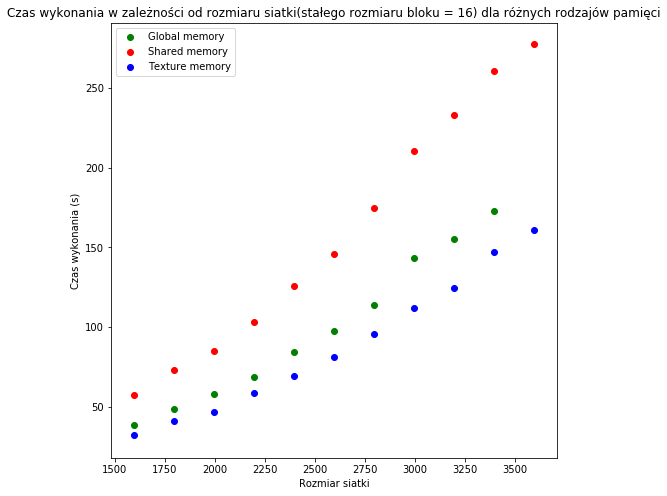

In [10]:
time_grid_size_with_big_size_of_grid()

# Analiza wpływu wielkości bloku wątków na wydajność obliczeń

In [63]:
def analyze_impact_of_size_of_block(file_name):
    memory_type = file_name[:-4].split("_")[0]
    dataframe = pd.read_csv(file_name)
    plt.figure(figsize=(16, 16))
    grouped_8 = dataframe[dataframe['block'] == 8]
    grouped_16 = dataframe[dataframe['block'] == 16]
    grouped_24 = dataframe[dataframe['block'] == 24]
    grouped_32 = dataframe[dataframe['block'] == 32 ]
    
    names = ["8", "16", "24", "32"]
    for idx, group in enumerate([grouped_8, grouped_16, grouped_24, grouped_32]):
        
        print ("Statystyki czasu wykonania dla {}, rozmiaru bloku: {}".format(memory_type, names[idx]))
        print(group['time '].describe())
        print("")
    
    a = plt.scatter(grouped_8['N'], grouped_8['time '], color='green')
    b = plt.scatter(grouped_16['N'], grouped_16['time '], color='red')
    c = plt.scatter(grouped_24['N'], grouped_24['time '], color='blue')
    d = plt.scatter(grouped_32['N'], grouped_32['time '], color='purple')
    plt.legend(['Blok 8', 'Blok 16', 'Blok 24', 'Blok 32'])
    plt.xlabel('Rozmiar siatki')
    plt.ylabel('Czas wykonania (s)')
    plt.title("Czas wykonania w zależności od rozmiaru siatki dla różnych rozmiarów bloku dla pamieci typu: " + 
              str(memory_type))
    plt.show()

Statystyki czasu wykonania dla global, rozmiaru bloku: 8
count    50.000000
mean     15.019740
std      13.131421
min       0.421567
25%       2.910835
50%      11.515000
75%      24.571075
max      42.224900
Name: time , dtype: float64

Statystyki czasu wykonania dla global, rozmiaru bloku: 16
count    50.000000
mean     12.569170
std      10.897435
min       0.417488
25%       2.429735
50%       9.627600
75%      20.458650
max      35.522900
Name: time , dtype: float64

Statystyki czasu wykonania dla global, rozmiaru bloku: 24
count    50.000000
mean     13.597120
std      11.757546
min       0.418620
25%       2.714618
50%      10.674700
75%      22.144200
max      38.137600
Name: time , dtype: float64

Statystyki czasu wykonania dla global, rozmiaru bloku: 32
count    50.000000
mean     13.191837
std      11.512621
min       0.467121
25%       2.596225
50%      10.093000
75%      21.484525
max      38.174700
Name: time , dtype: float64



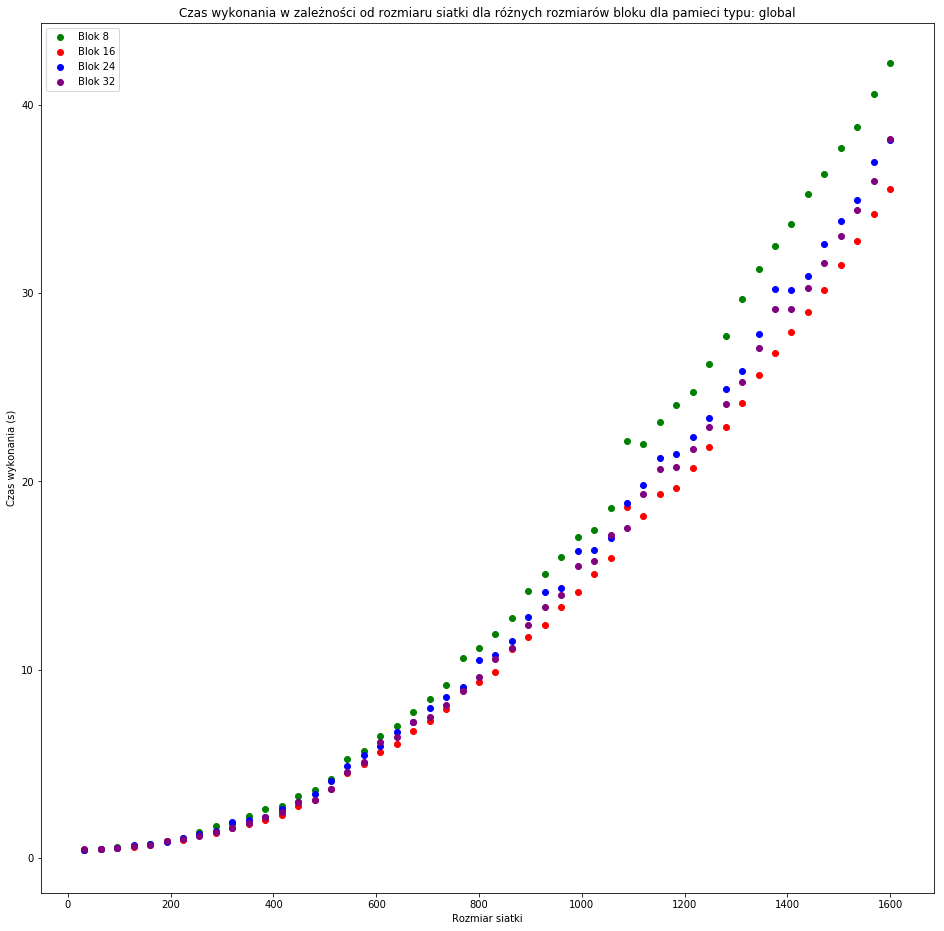

Statystyki czasu wykonania dla shared, rozmiaru bloku: 8
count    50.000000
mean     19.457468
std      16.904364
min       0.469663
25%       4.040730
50%      14.728850
75%      32.434875
max      54.770400
Name: time , dtype: float64

Statystyki czasu wykonania dla shared, rozmiaru bloku: 16
count    50.000000
mean     18.821484
std      16.430705
min       0.470214
25%       3.635495
50%      14.390100
75%      30.732575
max      53.506100
Name: time , dtype: float64

Statystyki czasu wykonania dla shared, rozmiaru bloku: 24
count    50.000000
mean     21.143945
std      18.474634
min       0.469982
25%       4.189493
50%      16.624350
75%      34.770425
max      59.979000
Name: time , dtype: float64

Statystyki czasu wykonania dla shared, rozmiaru bloku: 32
count     49.000000
mean      44.046937
std       38.705301
min        0.630300
25%        8.782430
50%       34.144100
75%       72.147300
max      126.292000
Name: time , dtype: float64



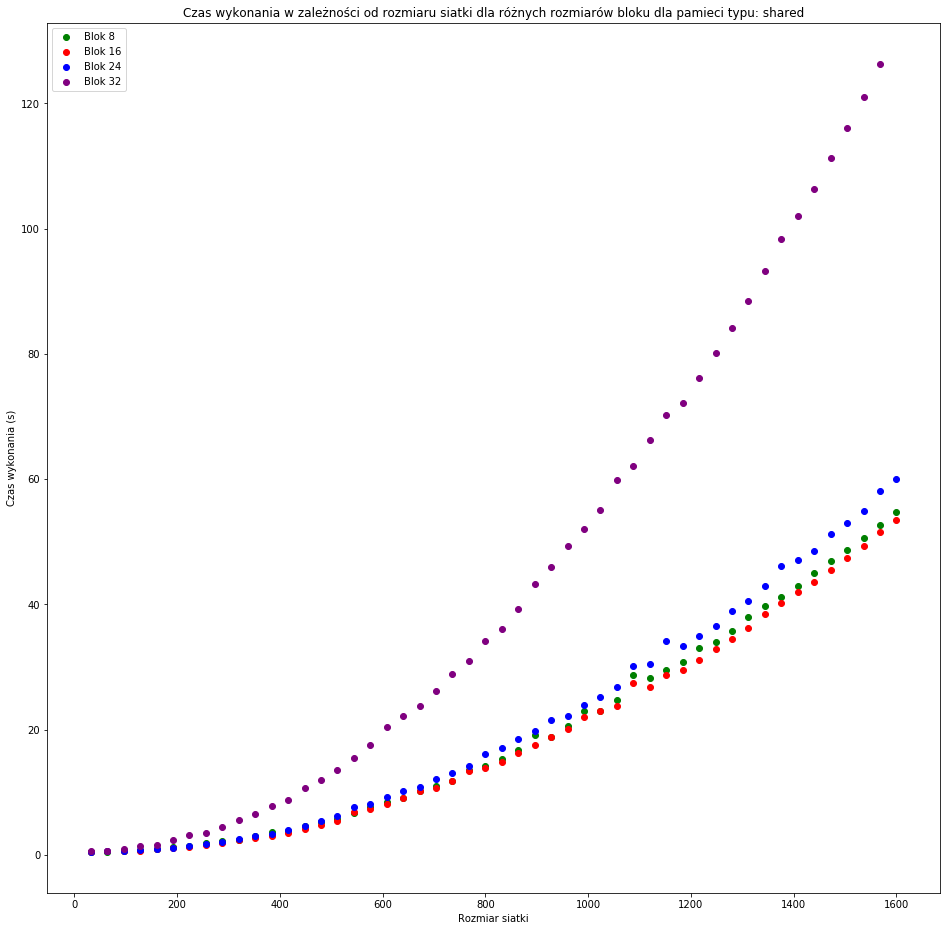

Statystyki czasu wykonania dla texture, rozmiaru bloku: 8
count    50.000000
mean     12.426994
std      10.705119
min       0.420616
25%       2.614312
50%       9.449545
75%      20.189100
max      34.633700
Name: time , dtype: float64

Statystyki czasu wykonania dla texture, rozmiaru bloku: 16
count    50.000000
mean     10.849263
std       9.372805
min       0.412188
25%       1.910068
50%       8.424470
75%      17.582500
max      30.285400
Name: time , dtype: float64

Statystyki czasu wykonania dla texture, rozmiaru bloku: 24
count    50.000000
mean     12.849698
std      11.144894
min       0.407597
25%       2.421158
50%      10.090855
75%      21.012950
max      36.115600
Name: time , dtype: float64

Statystyki czasu wykonania dla texture, rozmiaru bloku: 32
count    49.000000
mean     11.868047
std      10.271512
min       0.444891
25%       2.157460
50%       9.914190
75%      19.375200
max      33.309200
Name: time , dtype: float64



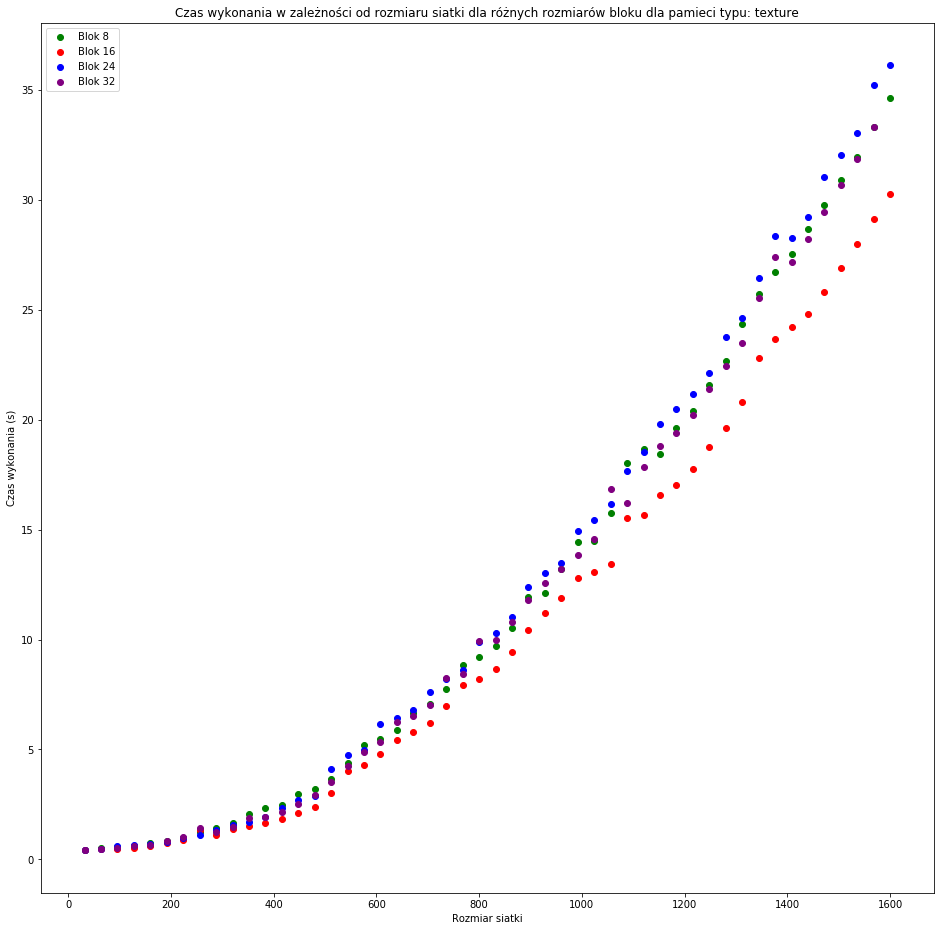

In [64]:
analyze_impact_of_size_of_block("global_results.txt")
analyze_impact_of_size_of_block("shared_results.txt")
analyze_impact_of_size_of_block("texture_results.txt")


# Porównanie czasu wykonania programu na GPU i CPU

In [83]:
# Porownanie czasu wykonania GPU/CPU
def compare_CPU_GPU():
    global_with_block_16 = global_results[global_results['block']==16]
    shared_results_16 = shared_results[shared_results['block'] == 16]
    texture_results_16 = texture_results[texture_results['block'] == 16]
    CPU = pd.read_csv("./cpu_results.txt")
    
    plt.figure(figsize=(10, 10))
    a = plt.scatter(global_with_block_16['N'], global_with_block_16['time '], color='green')
    b = plt.scatter(shared_results_16['N'], shared_results_16['time '], color='red')
    c = plt.scatter(texture_results_16['N'], texture_results_16['time '], color='blue')
    d = plt.scatter(CPU['N'], CPU['time '], color='black')
    plt.legend(['Global memory', 'Shared memory', 'Texture memory', 'CPU'])
    plt.xlabel('Rozmiar siatki')
    plt.ylabel('Czas wykonania (s)')
    plt.title("Czas wykonania na CPU i na GPU w zależnosci od  rozmiaru siatki(stałego rozmiaru bloku = 16)")
    plt.show()
    
    

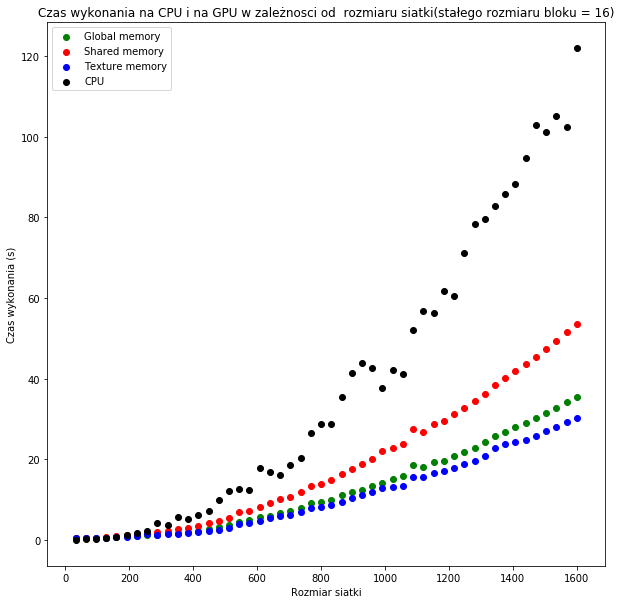

In [84]:
compare_CPU_GPU()

In [37]:
# Sprawdzanie teoretycznej i praktycznej wydajnosci
# Praktyczna wydajnosc:
global_occupancy = pd.read_csv("./metryki_global.txt")
shared_occupancy = pd.read_csv("./metryki_shared.txt")
texture_occupancy = pd.read_csv("./metryki_texture.txt")

global_occupancy.columns

Index(['N', 'block', 'update_min_occupancy', 'update_max_occupancy',
       'update_avg_occupancy', 'copy_min_occupancy', 'copy_max_occupancy',
       'copy_avg_occupancy'],
      dtype='object')

In [94]:
def occupancy():
    global_with_block_8 = global_occupancy[global_occupancy['block']==8]
    shared_results_8 = shared_occupancy[shared_occupancy['block'] == 8]
    texture_results_8 = texture_occupancy[texture_occupancy['block'] == 8]
    
    ####
    global_with_block_16 = global_occupancy[global_occupancy['block']==16]
    shared_results_16 = shared_occupancy[shared_occupancy['block'] == 16]
    texture_results_16 = texture_occupancy[texture_occupancy['block'] == 16]
    
    ###
    global_with_block_24 = global_occupancy[global_occupancy['block']==24]
    shared_results_24 = shared_occupancy[shared_occupancy['block'] == 24]
    texture_results_24 = texture_occupancy[texture_occupancy['block'] == 24]
    ###
    global_with_block_32 = global_occupancy[global_occupancy['block']==32]
    shared_results_32 = shared_occupancy[shared_occupancy['block'] == 32]
    texture_results_32 = texture_occupancy[texture_occupancy['block'] == 32]
    
    plt.figure(figsize=(12, 12))
    
    a = plt.scatter(global_with_block_8['N'], global_with_block_8['update_avg_occupancy'], color='green', marker='x')
    b = plt.scatter(shared_results_8['N'], shared_results_8['update_avg_occupancy'], color='red', marker='x')
    c = plt.scatter(texture_results_8['N'], texture_results_8['update_avg_occupancy'], color='blue', marker='x')
    ########
    d = plt.scatter(global_with_block_16['N'], global_with_block_16['update_avg_occupancy'], color='green', marker='o')
    e = plt.scatter(shared_results_16['N'], shared_results_16['update_avg_occupancy'], color='red', marker='o')
    f = plt.scatter(texture_results_16['N'], texture_results_16['update_avg_occupancy'], color='blue', marker='o')
    #########
    g = plt.scatter(global_with_block_24['N'], global_with_block_24['update_avg_occupancy'], color='green', marker='v')
    h = plt.scatter(shared_results_24['N'], shared_results_24['update_avg_occupancy'], color='red', marker='v')
    i = plt.scatter(texture_results_24['N'], texture_results_24['update_avg_occupancy'], color='blue', marker='v')
    ##########
    j = plt.scatter(global_with_block_32['N'], global_with_block_32['update_avg_occupancy'], color='green', marker='s')
    k = plt.scatter(shared_results_32['N'], shared_results_32['update_avg_occupancy'], color='red', marker='s')
    l = plt.scatter(texture_results_32['N'], texture_results_32['update_avg_occupancy'], color='blue', marker='s')
   
    plt.legend(['Global block=8', 'Shared block=8', 'Texture block=8', 'Global=16', 'Shared=16', 'Texture=16',
                'Global block=24', 'Shared block=24', 'Texture block=24', 'Global=32', 'Shared=32', 'Texture=32'])
    plt.yticks(np.arange(0.0, 1.0, step=0.05))
    plt.xlabel('Rozmiar siatki')
    plt.ylabel('Metryka achieved occupancy')
    plt.title('Analiza wpływu rozmiaru siatki i rozmiaru bloku na wykorzystanie multiprocesora')
    plt.show()

# Analiza wpływu rozmiaru siatki i rozmiaru bloku na wykorzystanie multiprocesora

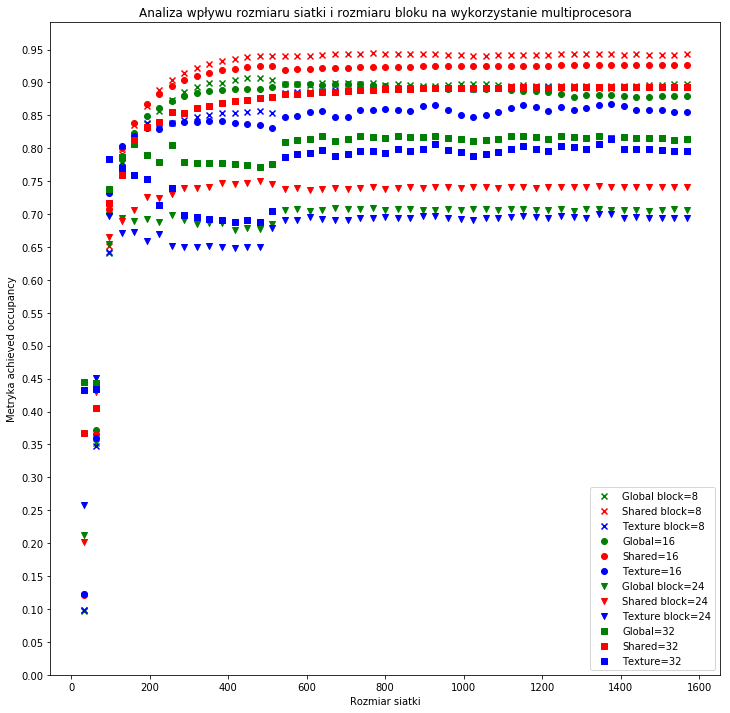

In [95]:
occupancy()